In [1]:
# General Libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours, RandomUnderSampler) 
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data = pd.read_csv('../data/2021/2021_brfss_new_ohe.csv')
data

,target,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220406,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
220407,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
220408,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
220409,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220411 entries, 0 to 220410
Data columns (total 64 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   target                                                220411 non-null  float64
 1   HighBP                                                220411 non-null  float64
 2   HighChol                                              220411 non-null  float64
 3   CholCheck                                             220411 non-null  float64
 4   Smoker                                                220411 non-null  float64
 5   Stroke                                                220411 non-null  float64
 6   PhysActivity                                          220411 non-null  float64
 7   Fruits                                                220411 non-null  float64
 8   Veggies                                     

Would Recommend:          0
0.0  200163
1.0   20248
Proportion Chance Criterion: 83.31%
1.25 * Proportion Chance Criterion: 104.14%


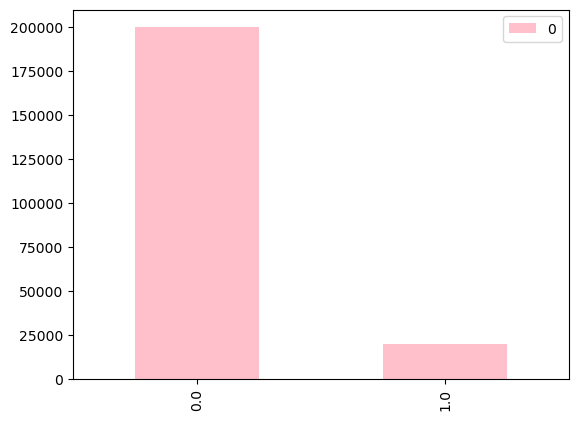

In [4]:
state_counts = Counter(data['target'])
data_state = pd.DataFrame.from_dict(state_counts, orient='index')
data_state.plot(kind='bar', color='pink')

num=(data_state[0]/data_state[0].sum())**2

print("Would Recommend:{}".format(data_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [5]:
X = data.drop(['target'], axis=1)
y = data['target']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=69, test_size=0.20,
                                                                  stratify=y)

In [55]:
def train_model(X, y, metric, model_type, res_t=None, hypertune=False, resample=False):
    # Determine Model
    if model_type == 'knn':
        model = KNeighborsClassifier()
        params = {"kneighborsclassifier__n_neighbors": range(2, 20, 2)}
    elif model_type == 'lr':
        model = LogisticRegression()
        params = {
            "model__C":  [1e-3,0.05, 0.1],
            "model__solver": ['liblinear','newton-cg','sag','lbfgs'],
            "model__max_iter":[100,1000]
        }
    elif model_type == 'gb':
        model = GradientBoostingClassifier(random_state=143)
        params = {
            "model__n_estimators": [1, 10, 50, 100, 200],
            "model__learning_rate": [1, 0.5, 0.1, 0.01]
        }

    # Create Imbalanced Pipeline
    if resample is True:
        imba_pipeline = Pipeline([
            ('res', res_t),
            ('model', model)
        ]) 
    else:
        imba_pipeline = Pipeline([
            ('model', model)
        ])

    # Hyperparameter tune
    if hypertune is True:
        clf = GridSearchCV(
                imba_pipeline, 
                param_grid=params,
                scoring=metric,
                return_train_score=True,
                refit=False,
                verbose=10
            )
        
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        best_params = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_recall').iloc[0]['params']
        imba_pipeline.set_params(**best_params)
        model = imba_pipeline.fit(X, y)

        return [type(model).__name__, 
                np.mean(clf.cv_results_['mean_train_accuracy']),
                np.mean(clf.cv_results_['mean_train_recall']),
                np.mean(clf.cv_results_['mean_test_accuracy']),
                np.mean(clf.cv_results_['mean_test_recall']), 
                'Best parameters = {0}'.format(best_params),
                run_time, 
                model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric,
                                   return_train_score=True)

        return [type(model).__name__, 
                np.mean(cv_scores['train_recall']),
                np.mean(cv_scores['train_accuracy']),
                np.mean(cv_scores['test_recall']),
                np.mean(cv_scores['train_accuracy']), run_time, clf]
        

In [50]:
start_time = time.time()
lr_tk_rec_ada = train_model(X_trainval, y_trainval, ['recall', 'accuracy'], 'knn', RandomUnderSampler(),
                       hypertune=True, resample=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START kneighborsclassifier__n_neighbors=2.........................
[CV 1/5; 1/8] END kneighborsclassifier__n_neighbors=2; accuracy: (train=0.867, test=0.834) recall: (train=0.523, test=0.312) total time=   1.6s
[CV 2/5; 1/8] START kneighborsclassifier__n_neighbors=2.........................
[CV 2/5; 1/8] END kneighborsclassifier__n_neighbors=2; accuracy: (train=0.865, test=0.835) recall: (train=0.516, test=0.302) total time=   1.4s
[CV 3/5; 1/8] START kneighborsclassifier__n_neighbors=2.........................
[CV 3/5; 1/8] END kneighborsclassifier__n_neighbors=2; accuracy: (train=0.866, test=0.840) recall: (train=0.514, test=0.327) total time=   1.5s
[CV 4/5; 1/8] START kneighborsclassifier__n_neighbors=2.........................
[CV 4/5; 1/8] END kneighborsclassifier__n_neighbors=2; accuracy: (train=0.866, test=0.838) recall: (train=0.523, test=0.319) total time=   1.5s
[CV 5/5; 1/8] START kneighborsclassifier

In [52]:
# re-fitting for the holdout
rh = lr_tk_rec_ada[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_rec = recall_score(y_holdout, y_preds)
rh_holdout_acc = accuracy_score(y_holdout, y_preds)

In [46]:
# cross-validation
base_var = train_model(X_trainval, y_trainval, ['recall', 'accuracy'], 'knn', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_recall = recall_score(y_holdout, y_preds)
holdout_accuracy = accuracy_score(y_holdout, y_preds)

In [54]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall', 'Train Accuracy', 'Val Accuracy', 'Holdout Accuracy']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                  '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                  '{:.2f}%'.format(np.round(base_var[3]*100, 2)),
                  '{:.2f}%'.format(np.round(holdout_recall*100, 2)),
                  '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                  '{:.2f}%'.format(np.round(base_var[4]*100, 2)),
                  '{:.2f}%'.format(np.round(holdout_accuracy*100, 2))]
summary.loc[1] = ['ReSampling x HyperTune',
                  '{:.2f}%'.format(np.round(lr_tk_rec_ada[2]*100, 2)),
                  '{:.2f}%'.format(np.round(lr_tk_rec_ada[4]*100, 2)),
                  '{:.2f}%'.format(np.round(rh_holdout_rec*100, 2)),
                  '{:.2f}%'.format(np.round(lr_tk_rec_ada[1]*100, 2)),
                  '{:.2f}%'.format(np.round(lr_tk_rec_ada[3]*100, 2)),
                  '{:.2f}%'.format(np.round(rh_holdout_acc*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall,Train Accuracy,Val Accuracy,Holdout Accuracy
No Resampling,21.36%,9.32%,9.33%,91.86%,91.86%,89.86%
ReSampling x HyperTune,63.41%,50.61%,58.77%,80.95%,50.61%,77.02%
